In [ ]:
 #Haris Amaldi
 #Dilarang keras mengcopy kode ini! PLAGIARISME ITU HARAM!

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

In [ ]:
data_train = pd.read_csv('Indian Summers - Over the years.csv')
data_train.head()

,City,Date,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description
0,New Delhi,2021-04-01,34.0,19.0,27.1,31.6,19.0,26.1,3.1,22.60,22.8,272.9,1002.8,0.0,3.1,2021-04-01 06:11:12,2021-04-01 18:39:13,0.60,Clear,Clear conditions throughout the day.
1,New Delhi,2021-04-02,33.9,16.0,25.8,31.8,16.0,24.9,4.5,27.62,12.4,275.0,1006.2,0.0,3.5,2021-04-02 06:10:04,2021-04-02 18:39:46,0.65,Clear,Clear conditions throughout the day.
2,New Delhi,2021-04-03,34.8,14.6,26.0,32.2,14.6,25.1,1.3,23.18,16.5,127.5,1008.8,1.4,3.5,2021-04-03 06:08:55,2021-04-03 18:40:19,0.70,Clear,Clear conditions throughout the day.
3,New Delhi,2021-04-04,36.8,16.9,27.1,34.2,16.9,26.0,4.8,28.00,18.3,157.6,1009.5,2.6,3.2,2021-04-04 06:07:47,2021-04-04 18:40:53,0.76,Clear,Clear conditions throughout the day.
4,New Delhi,2021-04-05,38.8,21.0,29.9,37.1,21.0,28.9,8.1,28.85,13.5,100.4,1007.8,38.4,3.1,2021-04-05 06:06:39,2021-04-05 18:41:26,0.81,Partially cloudy,Partly cloudy throughout the day.


In [ ]:
len(data_train)

13650

In [ ]:
data_train.isnull().sum()

City                   0
Date                   0
tempmax               35
tempmin               35
temp                  45
feelslikemax          36
feelslikemin          36
feelslike             46
dew                   45
humidity              45
windspeed             45
winddir               50
sealevelpressure    3019
cloudcover            45
visibility            45
sunrise                0
sunset                 0
moonphase              0
conditions            45
description           45
dtype: int64

In [ ]:
data_train.dropna(subset=['temp'],inplace=True)
data_train.isnull().sum()

City                   0
Date                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           1
feelslikemin           1
feelslike              1
dew                    0
humidity               0
windspeed              0
winddir                5
sealevelpressure    2974
cloudcover             0
visibility             0
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
Tanggal = data_train['Date'].values
Temp = data_train['temp'].values
Tanggal_train, Tanggal_test, Temp_train, Temp_test = train_test_split(Tanggal, Temp, train_size=0.8, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
P_train = scaler.fit([Temp_train])
P_test = scaler.fit([Temp_test])

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(Temp_train, window_size=64, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(Temp_test, window_size=64, batch_size=200, shuffle_buffer=1000)


model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True))),
model.add(Bidirectional(LSTM(64))),
model.add(Dropout(0.5)),
model.add(Dense(64, activation="relu")),
model.add(Dense(32, activation="relu")),
model.add(Dense(1))

In [ ]:
#mencari nilai MAE 10% skala data
Mae = (data_train['temp'].max() - data_train['temp'].min())*0.1
print(Mae)

2.06


In [ ]:
#Hentikan jika MAE <10% skala data
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.06 and logs.get('val_mae')<2.06):
      print("Anda sudah berhasil menjalankan Proyek Time Series ini. MAE model ini sudah <10%. Selamat!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = test_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


55/55 [==============================] - 15s 164ms/step - loss: 29.4826 - mae: 29.9826 - val_loss: 27.9757 - val_mae: 28.4757
Epoch 2/100
55/55 [==============================] - 7s 132ms/step - loss: 26.0135 - mae: 26.5135 - val_loss: 22.7501 - val_mae: 23.2501
Epoch 3/100
55/55 [==============================] - 8s 133ms/step - loss: 15.0621 - mae: 15.5599 - val_loss: 2.1555 - val_mae: 2.6145
Epoch 4/100
55/55 [==============================] - 8s 133ms/step - loss: 3.3459 - mae: 3.8186 - val_loss: 2.0186 - val_mae: 2.4723
Epoch 5/100
55/55 [==============================] - 8s 133ms/step - loss: 3.2254 - mae: 3.6960 - val_loss: 1.9932 - val_mae: 2.4449
Epoch 6/100
55/55 [==============================] - 8s 133ms/step - loss: 3.1840 - mae: 3.6556 - val_loss: 1.9762 - val_mae: 2.4267
Epoch 7/100
55/55 [==============================] - 8s 133ms/step - loss: 3.1095 - mae: 3.5796 - val_loss: 1.9678 - val_mae: 2.4181
Epoch 8/100
55/55 [==============================] - 8s 142ms/step - l

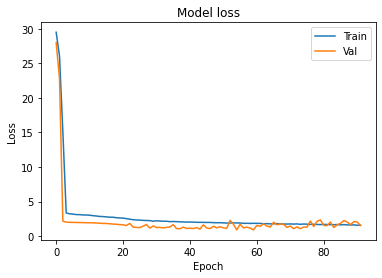

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

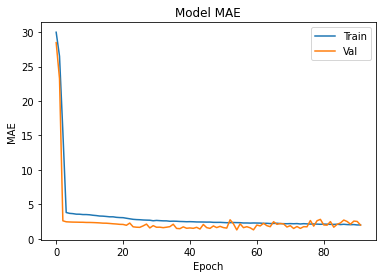

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()